In [1]:
import findspark
findspark.init('/home/sdmohant/spark-3.0.0-bin-hadoop2.7')

In [2]:
import pyspark
from pyspark import SparkContext,SparkConf

In [3]:
from pyspark.sql import SparkSession

In [4]:
#spark = SparkSession.builder.appName("MyApp").getOrCreate()
#spark = SparkSession.builder.appName("MyName").getOrCreate()
conf = SparkConf().set("spark.cores.max", "16") \
    .set("spark.driver.memory", "16g") \
    .set("spark.executor.memory", "16g") \
    .set("spark.executor.memory_overhead", "16g") \
    .set("spark.driver.maxResultsSize", "0") \
    .set("spark.sql.shuffle.partitions","300")

sc = SparkContext(appName="newApp", conf=conf)
spark = SparkSession(sc)

/home/sdmohant/spark-3.0.0-bin-hadoop2.7/python/pyspark/context.py:220: DeprecationWarning: Support for Python 2 and Python 3 prior to version 3.6 is deprecated as of Spark 3.0. See also the plan for dropping Python 2 support at https://spark.apache.org/news/plan-for-dropping-python-2-support.html.
  DeprecationWarning)


In [5]:
from pyspark.sql.functions import isnan, count, col

In [6]:
df1 = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("AutPapJouCSCI.csv")

In [7]:
df1.printSchema()

root
 |-- PaperID: long (nullable = true)
 |-- Paper_Rank: integer (nullable = true)
 |-- Paper_RefCnt: integer (nullable = true)
 |-- CitationCount: integer (nullable = true)
 |-- EstimatedCount: integer (nullable = true)
 |-- Journal_Rank: integer (nullable = true)
 |-- Journal_Pap_Cnt: integer (nullable = true)
 |-- Journal_Cit_Cnt: integer (nullable = true)
 |-- CSRank: integer (nullable = true)
 |-- CSPaperCount: integer (nullable = true)
 |-- CSCitation: integer (nullable = true)
 |-- CIRank: integer (nullable = true)
 |-- CIPaperCount: integer (nullable = true)
 |-- CIPaperCitationCnt: integer (nullable = true)
 |-- DocTypeIndex: double (nullable = true)
 |-- max_AuthorRank: integer (nullable = true)
 |-- min_AutPaperCount: integer (nullable = true)
 |-- max_AutPaperCount: integer (nullable = true)
 |-- min_AutCitationCount: integer (nullable = true)
 |-- max_AutCitationCount: integer (nullable = true)
 |-- min_AuthorRank: integer (nullable = true)



In [8]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd

In [9]:
df1_reordered = df1.select("PaperID","Paper_Rank","Paper_RefCnt","EstimatedCount","Journal_Rank","Journal_Pap_Cnt","Journal_Cit_Cnt","CSRank","CSPaperCount","CSCitation","CIRank","CIPaperCount","CIPaperCitationCnt","DocTypeIndex","max_AuthorRank","min_AutPaperCount","max_AutPaperCount","min_AutCitationCount","max_AutCitationCount","min_AuthorRank","CitationCount")

In [10]:
df1_reordered.printSchema()

root
 |-- PaperID: long (nullable = true)
 |-- Paper_Rank: integer (nullable = true)
 |-- Paper_RefCnt: integer (nullable = true)
 |-- EstimatedCount: integer (nullable = true)
 |-- Journal_Rank: integer (nullable = true)
 |-- Journal_Pap_Cnt: integer (nullable = true)
 |-- Journal_Cit_Cnt: integer (nullable = true)
 |-- CSRank: integer (nullable = true)
 |-- CSPaperCount: integer (nullable = true)
 |-- CSCitation: integer (nullable = true)
 |-- CIRank: integer (nullable = true)
 |-- CIPaperCount: integer (nullable = true)
 |-- CIPaperCitationCnt: integer (nullable = true)
 |-- DocTypeIndex: double (nullable = true)
 |-- max_AuthorRank: integer (nullable = true)
 |-- min_AutPaperCount: integer (nullable = true)
 |-- max_AutPaperCount: integer (nullable = true)
 |-- min_AutCitationCount: integer (nullable = true)
 |-- max_AutCitationCount: integer (nullable = true)
 |-- min_AuthorRank: integer (nullable = true)
 |-- CitationCount: integer (nullable = true)



In [11]:
df2 = df1_reordered.withColumnRenamed("CitationCount","label")

In [24]:
drop_cols = ["PaperID","EstimatedCount"]
df2 = df2.drop(*drop_cols)

In [25]:
from pyspark.ml.feature import VectorAssembler, VectorIndexer
feature_list = []
for col in df2.columns:
    if col == 'label':
        continue
    else:
        feature_list.append(col)
# Concatenates all feature columns into a single feature vector in a new column "rawFeatures"
vectorAssembler = VectorAssembler(inputCols=feature_list, outputCol="features")
# Identifies categorical features and indexes them
#vectorIndexer = VectorIndexer(inputCol="rawFeatures", outputCol="features", maxCategories=4)

In [26]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

In [27]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(labelCol="label", featuresCol="features")
#rf = RandomForestRegressor(featuresCol="features")

In [28]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[vectorAssembler, rf])

In [29]:
from pyspark.ml.tuning import ParamGridBuilder
import numpy as np

paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()

In [30]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)

In [31]:
(train, test) = df2.randomSplit([0.8, 0.2])

In [32]:
cvModel = crossval.fit(train)

In [33]:
predictions = cvModel.transform(test)

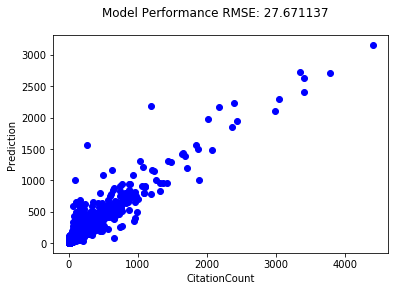

In [34]:
import matplotlib.pyplot as plt

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions)

rfPred = cvModel.transform(df2)

rfResult = rfPred.toPandas()

plt.plot(rfResult.label, rfResult.prediction, 'bo')
plt.xlabel('CitationCount')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

Text(0.5,1,'Feature Importances')

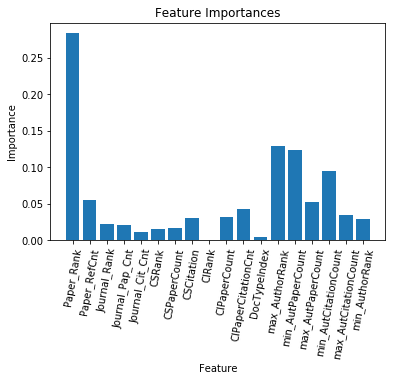

In [35]:
bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[1]

importances = bestModel.featureImportances

x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=80)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

In [36]:
from pyspark.ml.regression import GBTRegressor
# Takes the "features" column and learns to predict "cnt"
gbt = GBTRegressor(labelCol="label")

In [37]:
paramGrid = ParamGridBuilder()\
  .addGrid(gbt.maxDepth, [2, 5])\
  .addGrid(gbt.maxIter, [10, 100])\
  .build()
evaluator = RegressionEvaluator(metricName="r2", labelCol=gbt.getLabelCol(), predictionCol=gbt.getPredictionCol())
cv = CrossValidator(estimator=gbt, evaluator=evaluator, estimatorParamMaps=paramGrid)

In [38]:
pipeline = Pipeline(stages=[vectorAssembler, cv])

In [39]:
pipelineModel = pipeline.fit(train)

In [40]:
predictions = pipelineModel.transform(test)
display(predictions.select("label", "prediction", *feature_list))

DataFrame[label: int, prediction: double, Paper_Rank: int, Paper_RefCnt: int, Journal_Rank: int, Journal_Pap_Cnt: int, Journal_Cit_Cnt: int, CSRank: int, CSPaperCount: int, CSCitation: int, CIRank: int, CIPaperCount: int, CIPaperCitationCnt: int, DocTypeIndex: double, max_AuthorRank: int, min_AutPaperCount: int, max_AutPaperCount: int, min_AutCitationCount: int, max_AutCitationCount: int, min_AuthorRank: int]

In [41]:
r2 = evaluator.evaluate(predictions)
print("R2 on our test set: %g" % r2)

R2 on our test set: 0.578267


In [42]:
paramGrid = ParamGridBuilder()\
  .addGrid(gbt.maxDepth, [2, 7])\
  .addGrid(gbt.maxIter, [10, 100])\
  .build()
evaluator = RegressionEvaluator(metricName="rmse", labelCol=gbt.getLabelCol(), predictionCol=gbt.getPredictionCol())
cv = CrossValidator(estimator=gbt, evaluator=evaluator, estimatorParamMaps=paramGrid)

In [43]:
pipeline = Pipeline(stages=[vectorAssembler, cv])

In [44]:
pipelineModel = pipeline.fit(train)

In [45]:
predictions = pipelineModel.transform(test)
display(predictions.select("label", "prediction", *feature_list))

DataFrame[label: int, prediction: double, Paper_Rank: int, Paper_RefCnt: int, Journal_Rank: int, Journal_Pap_Cnt: int, Journal_Cit_Cnt: int, CSRank: int, CSPaperCount: int, CSCitation: int, CIRank: int, CIPaperCount: int, CIPaperCitationCnt: int, DocTypeIndex: double, max_AuthorRank: int, min_AutPaperCount: int, max_AutPaperCount: int, min_AutCitationCount: int, max_AutCitationCount: int, min_AuthorRank: int]

In [46]:
rmse = evaluator.evaluate(predictions)
print("RMSE on our test set: %g" % rmse)

RMSE on our test set: 32.4973


In [47]:
df2 = df1_reordered.withColumnRenamed("EstimatedCount","label")

In [48]:
drop_cols = ["PaperID","CitationCount"]
df2 = df2.drop(*drop_cols)

In [49]:
from pyspark.ml.feature import VectorAssembler, VectorIndexer
feature_list = []
for col in df2.columns:
    if col == 'label':
        continue
    else:
        feature_list.append(col)
# Concatenates all feature columns into a single feature vector in a new column "rawFeatures"
vectorAssembler = VectorAssembler(inputCols=feature_list, outputCol="features")
# Identifies categorical features and indexes them
#vectorIndexer = VectorIndexer(inputCol="rawFeatures", outputCol="features", maxCategories=4)

In [50]:
rf = RandomForestRegressor(labelCol="label", featuresCol="features")

In [51]:
pipeline = Pipeline(stages=[vectorAssembler, rf])

In [52]:
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()

In [53]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(),
                          numFolds=3)

In [54]:
(train, test) = df2.randomSplit([0.8, 0.2])

In [55]:
cvmodel= crossval.fit(train)

In [56]:
cvmodel.transform(test)

DataFrame[Paper_Rank: int, Paper_RefCnt: int, label: int, Journal_Rank: int, Journal_Pap_Cnt: int, Journal_Cit_Cnt: int, CSRank: int, CSPaperCount: int, CSCitation: int, CIRank: int, CIPaperCount: int, CIPaperCitationCnt: int, DocTypeIndex: double, max_AuthorRank: int, min_AutPaperCount: int, max_AutPaperCount: int, min_AutCitationCount: int, max_AutCitationCount: int, min_AuthorRank: int, features: vector, prediction: double]

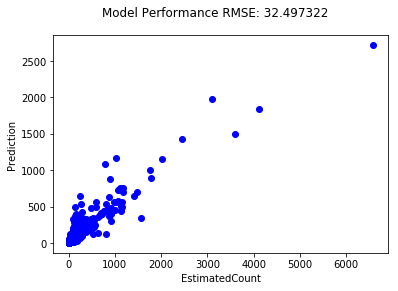

In [61]:

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(predictions)

rfPred = cvModel.transform(test)

rfResult = rfPred.toPandas()

plt.plot(rfResult.label, rfResult.prediction, 'bo')
plt.xlabel('EstimatedCount')
plt.ylabel('Prediction')
plt.suptitle("Model Performance RMSE: %f" % rmse)
plt.show()

Text(0.5,1,'Feature Importances')

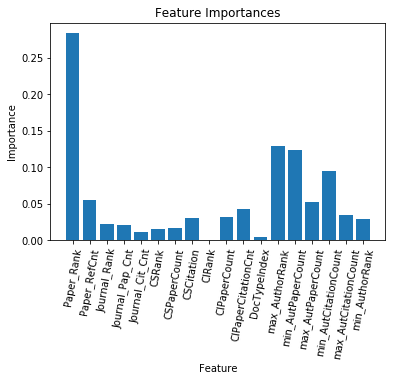

In [62]:
bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[1]

importances = bestModel.featureImportances

x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=80)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')